## Imports

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import calendar
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

## Utils

In [21]:
def get_days_in_month(year, month):
    _, num_days = calendar.monthrange(year, month)
    return num_days

def get_day_in_year(year, month, day):
    day_in_year = 0

    for m in range(1, month):
        day_in_year += get_days_in_month(year, m)

    day_in_year += day - 1

    return day_in_year

def add_hour_features(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    return df
def add_day_in_year_features(df):
    # Convertir la variable 'day_in_year' a variables cícliches
    df['day_in_year_sin'] = np.sin(2 * np.pi * df['day_in_year'] / 365)
    df['day_in_year_cos'] = np.cos(2 * np.pi * df['day_in_year'] / 365)
    
    return df

def add_time_features(df):
    df = add_hour_features(df)
    
    df = add_day_in_year_features(df)
    
    return df


## Tractament de dades

In [22]:
observations = pd.read_csv("../Data/gene_sconcno2_2023_xvpca_emep_port.csv")
stations_info = pd.read_csv("../Data/XVPCA_info_sconcno2_2023.csv")

In [23]:
stations_info['type'].unique()

array(['urban-centre', 'F – Fons', 'urban-suburban', 'R - Rural', 'LOCAL'],
      dtype=object)

In [24]:
unique_stations = observations.columns[1:]  # Excluim la columna "Date"
stations_train, stations_test = train_test_split(unique_stations, test_size=0.2, random_state=42)

observations_training = observations[["Date"] + stations_train.tolist()]
observations_testing = observations[["Date"] + stations_test.tolist()]

observations_training = observations_training.melt(id_vars=["Date"], var_name="Station", value_name="concentration")
observations_testing = observations_testing.melt(id_vars=["Date"], var_name="Station", value_name="concentration")

stations_info.rename(columns={"code": "Station", "lat": "Latitude", "lon": "Longitude"}, inplace=True)

observations_training = observations_training.merge(stations_info, on="Station", how="left")
observations_testing = observations_testing.merge(stations_info, on="Station", how="left")

observations_training = observations_training[["Date", "Latitude", "Longitude", "concentration"]]
observations_testing = observations_testing[["Date", "Latitude", "Longitude", "concentration"]]

observations_training.rename(columns={"Date": "date", "Latitude": "lat", "Longitude": "lon"}, inplace=True)
observations_testing.rename(columns={"Date": "date", "Latitude": "lat", "Longitude": "lon"}, inplace=True)

observations_training.dropna(subset=["lat", "lon", "concentration"], inplace=True)
observations_testing.dropna(subset=["lat", "lon", "concentration"], inplace=True)

In [25]:
observations_training

,date,lat,lon,concentration
0,2022-12-31 23:00:00,41.313475,2.013825,25.0
1,2023-01-01 00:00:00,41.313475,2.013825,36.0
2,2023-01-01 01:00:00,41.313475,2.013825,36.0
3,2023-01-01 02:00:00,41.313475,2.013825,35.0
4,2023-01-01 03:00:00,41.313475,2.013825,28.0
...,...,...,...,...
446755,2023-12-31 18:00:00,41.103678,1.200765,19.0
446756,2023-12-31 19:00:00,41.103678,1.200765,19.0
446757,2023-12-31 20:00:00,41.103678,1.200765,13.0
446758,2023-12-31 21:00:00,41.103678,1.200765,9.0


In [26]:
data_transformed_training = observations_training.copy()

data_transformed_training['date'] = pd.to_datetime(data_transformed_training['date'])

data_transformed_training['day_in_year'] = data_transformed_training.apply(
    lambda row: get_day_in_year(row['date'].year, row['date'].month, row['date'].day), axis=1
)
data_transformed_training['hour'] = data_transformed_training['date'].dt.hour

data_transformed_training = data_transformed_training.drop(columns=['date'])

data_transformed_testing = observations_testing.copy()

data_transformed_testing['date'] = pd.to_datetime(data_transformed_testing['date'])

data_transformed_testing['day_in_year'] = data_transformed_testing.apply(
    lambda row: get_day_in_year(row['date'].year, row['date'].month, row['date'].day), axis=1
)
data_transformed_testing['hour'] = data_transformed_testing['date'].dt.hour

data_transformed_testing = data_transformed_testing.drop(columns=['date'])

print("Exemple Data Transformed Training:")
data_transformed_training.iloc[9999]

Exemple Data Transformed Training:


lat              41.102222
lon               1.149444
concentration    15.000000
day_in_year      77.000000
hour             19.000000
Name: 10628, dtype: float64

In [27]:
X_train = data_transformed_training[["lat", "lon", "day_in_year", "hour"]]
y_train = data_transformed_training["concentration"]

X_test = data_transformed_testing[["lat", "lon", "day_in_year", "hour"]]
y_test = data_transformed_testing["concentration"]

In [28]:
# Afegir les característiques cícliches per 'day_in_year' i 'hour' a X_train
X_train_transformed = add_time_features(X_train)

# Afegir les característiques cícliches per 'day_in_year' i 'hour' a X_test
X_test_transformed = add_time_features(X_test)

# Eliminar les columnes originals 'day_in_year' i 'hour'
X_train_transformed = X_train_transformed.drop(columns=["day_in_year", "hour"])
X_test_transformed = X_test_transformed.drop(columns=["day_in_year", "hour"])

# Comprovem els resultats
print(X_train_transformed.head())
print(X_test_transformed.head())

         lat       lon  hour_sin  hour_cos  day_in_year_sin  day_in_year_cos
0  41.313475  2.013825 -0.258819  0.965926        -0.017213         0.999852
1  41.313475  2.013825  0.000000  1.000000         0.000000         1.000000
2  41.313475  2.013825  0.258819  0.965926         0.000000         1.000000
3  41.313475  2.013825  0.500000  0.866025         0.000000         1.000000
4  41.313475  2.013825  0.707107  0.707107         0.000000         1.000000
         lat       lon      hour_sin  hour_cos  day_in_year_sin  \
37  42.36839  1.776814  1.224647e-16 -1.000000         0.017213   
38  42.36839  1.776814 -2.588190e-01 -0.965926         0.017213   
39  42.36839  1.776814 -5.000000e-01 -0.866025         0.017213   
40  42.36839  1.776814 -7.071068e-01 -0.707107         0.017213   
41  42.36839  1.776814 -8.660254e-01 -0.500000         0.017213   

    day_in_year_cos  
37         0.999852  
38         0.999852  
39         0.999852  
40         0.999852  
41         0.999852  


In [29]:
X_test

,lat,lon,day_in_year,hour,hour_sin,hour_cos,day_in_year_sin,day_in_year_cos
37,42.36839,1.776814,1,12,1.224647e-16,-1.000000e+00,0.017213,0.999852
38,42.36839,1.776814,1,13,-2.588190e-01,-9.659258e-01,0.017213,0.999852
39,42.36839,1.776814,1,14,-5.000000e-01,-8.660254e-01,0.017213,0.999852
40,42.36839,1.776814,1,15,-7.071068e-01,-7.071068e-01,0.017213,0.999852
41,42.36839,1.776814,1,16,-8.660254e-01,-5.000000e-01,0.017213,0.999852
...,...,...,...,...,...,...,...,...
113875,41.73028,1.825306,364,18,-1.000000e+00,-1.836970e-16,-0.017213,0.999852
113876,41.73028,1.825306,364,19,-9.659258e-01,2.588190e-01,-0.017213,0.999852
113877,41.73028,1.825306,364,20,-8.660254e-01,5.000000e-01,-0.017213,0.999852
113878,41.73028,1.825306,364,21,-7.071068e-01,7.071068e-01,-0.017213,0.999852


## Models

In [30]:
models = [
    ("Random Forest", RandomForestRegressor(random_state=42, n_estimators=10))
]

for model_name, model in models:
    print(f"\nTesting model: {model_name}")
    
    model.fit(X_train_transformed, y_train)
    
    y_pred = model.predict(X_test_transformed)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R2): {r2}")
    
    comparison = data_transformed_testing.copy()
    comparison["predicted_concentration"] = y_pred
    print("\nComparison of Actual vs Predicted:")
    print(comparison[["concentration", "predicted_concentration"]].head())


Testing model: Random Forest
Root Mean Squared Error (RMSE): 11.378556737169593
R-squared (R2): 0.39808857956703436

Comparison of Actual vs Predicted:
    concentration  predicted_concentration
37           16.0                     16.1
38            9.0                     18.2
39            7.0                     24.7
40           11.0                     31.4
41           29.0                     45.3


In [31]:
def prepare_predictions_with_date(X_test, y_pred, year, minute):
    predictions_df = X_test.copy()

    predictions_df['concentration'] = y_pred

    predictions_df['date'] = pd.to_datetime(predictions_df['day_in_year'], format='%j', errors='coerce').apply(
        lambda x: x.replace(year=year) if pd.notnull(x) else x)
    
    predictions_df['date'] = predictions_df.apply(
        lambda row: row['date'].replace(hour=row['hour'], minute=minute) if pd.notnull(row['date']) else row['date'],
        axis=1)
    
    predictions_df['date'] = predictions_df['date'].dt.strftime('%Y-%m-%d %H:%M')

    predictions_df = predictions_df.sort_values(by='date', ascending=True)

    predictions_df['id'] = range(1, len(predictions_df) + 1)

    result_df = predictions_df[['id', 'date', 'lat', 'lon', 'concentration']]

    return result_df

In [32]:
year = 2023
minute = 0

result_df = prepare_predictions_with_date(X_test, y_pred, year, minute)


print(result_df.head())

       id              date        lat       lon  concentration
17545   1  2023-01-01 00:00  41.317277  2.134501           52.6
35065   2  2023-01-01 00:00  41.403716  2.204736           39.0
61345   3  2023-01-01 00:00  41.321495  2.097725           22.6
87625   4  2023-01-01 00:00  40.706709  0.581651            9.6
43825   5  2023-01-01 00:00  41.150779  1.120172            7.6


## Generem una predicció per a les 4 estacions del kaggle

In [33]:
def generate_X_test(locations, year):
    
    days_in_year = 366 if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)) else 365
    
    data = []

    for lat, lon in locations:
        for day_in_year in range(1, days_in_year + 1):
            for hour in range(0, 24):
                data.append([lat, lon, day_in_year, hour])
    
    X_test = pd.DataFrame(data, columns=["lat", "lon", "day_in_year", "hour"])

    return X_test

In [34]:
locations = [(41.39216, 2.009802), (41.11588, 1.191975), (41.44398, 2.237875), (41.32177, 2.082141)]

X_test_Kaggle = generate_X_test(locations, 2023)

X_test_Kaggle_transformed = add_time_features(X_test_Kaggle)

X_test_Kaggle_transformed = X_test_Kaggle_transformed.drop(columns=["day_in_year", "hour"])

X_test_Kaggle_transformed

,lat,lon,hour_sin,hour_cos,day_in_year_sin,day_in_year_cos
0,41.39216,2.009802,0.000000,1.000000,1.721336e-02,0.999852
1,41.39216,2.009802,0.258819,0.965926,1.721336e-02,0.999852
2,41.39216,2.009802,0.500000,0.866025,1.721336e-02,0.999852
3,41.39216,2.009802,0.707107,0.707107,1.721336e-02,0.999852
4,41.39216,2.009802,0.866025,0.500000,1.721336e-02,0.999852
...,...,...,...,...,...,...
35035,41.32177,2.082141,-0.965926,0.258819,6.432491e-16,1.000000
35036,41.32177,2.082141,-0.866025,0.500000,6.432491e-16,1.000000
35037,41.32177,2.082141,-0.707107,0.707107,6.432491e-16,1.000000
35038,41.32177,2.082141,-0.500000,0.866025,6.432491e-16,1.000000


In [35]:
year = 2023
minute = 0

model = RandomForestRegressor(random_state=42, n_estimators=70)
model.fit(X_train_transformed, y_train)

y_pred_Kaggle = model.predict(X_test_Kaggle_transformed)

resultat_kaggle = prepare_predictions_with_date(X_test_Kaggle, y_pred_Kaggle, year, minute)
resultat_kaggle

#Creem un csv amb els resultats
resultat_kaggle.to_csv('predictions_kaggle.csv', index=False)

In [36]:
resultat_kaggle

,id,date,lat,lon,concentration
0,1,2023-01-01 00:00,41.39216,2.009802,24.185714
8760,2,2023-01-01 00:00,41.11588,1.191975,20.100000
17520,3,2023-01-01 00:00,41.44398,2.237875,39.300000
26280,4,2023-01-01 00:00,41.32177,2.082141,23.828571
8761,5,2023-01-01 01:00,41.11588,1.191975,18.071429
...,...,...,...,...,...
8758,35036,2023-12-31 22:00,41.39216,2.009802,25.157143
17519,35037,2023-12-31 23:00,41.11588,1.191975,20.257143
8759,35038,2023-12-31 23:00,41.39216,2.009802,26.714286
26279,35039,2023-12-31 23:00,41.44398,2.237875,42.728571


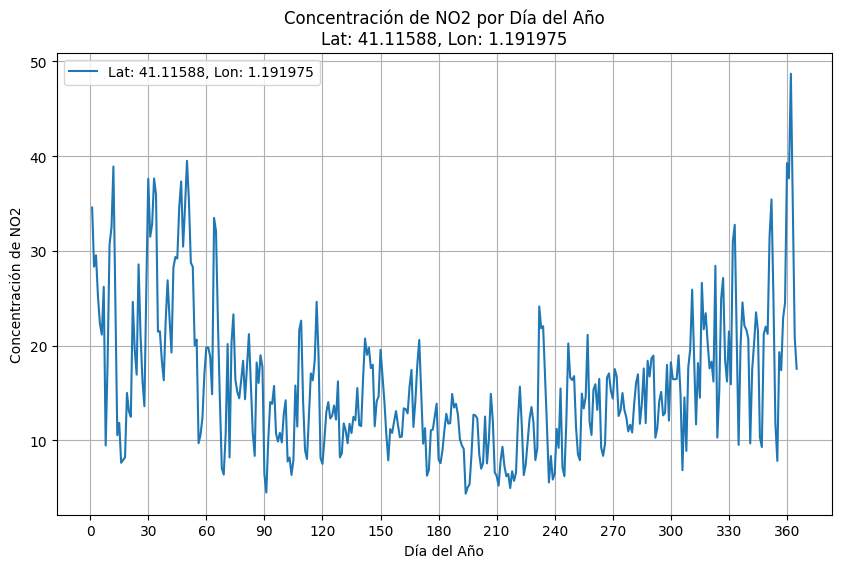

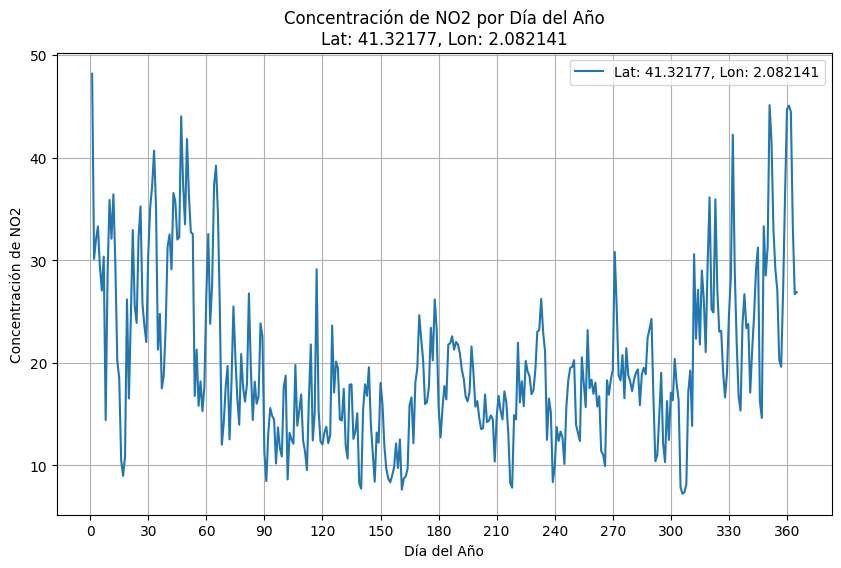

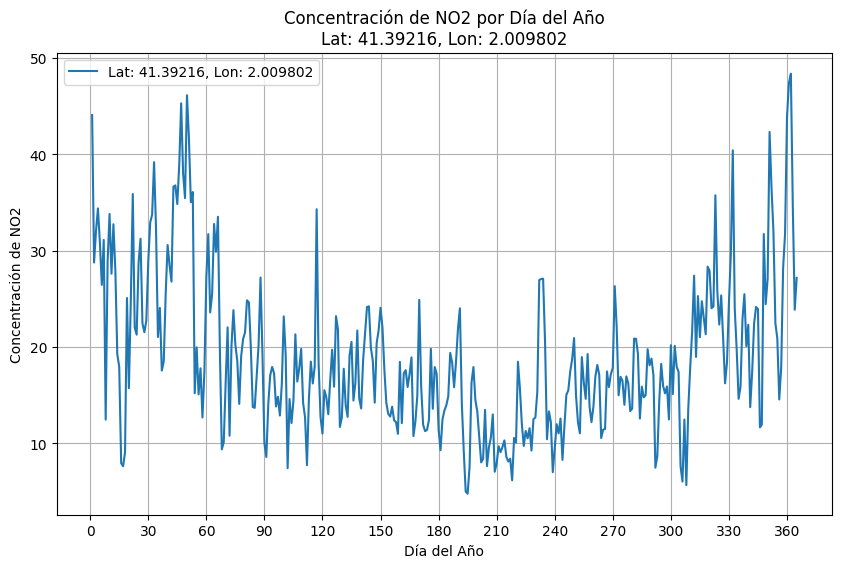

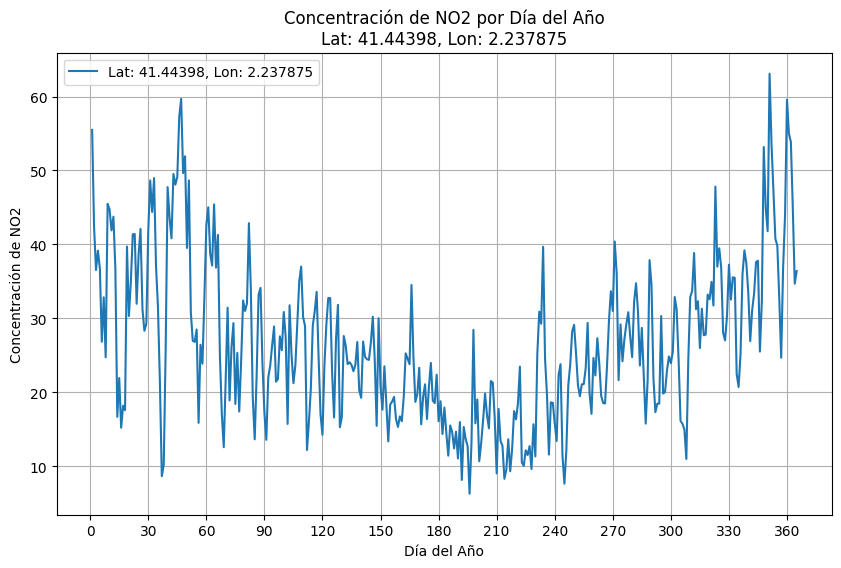

In [37]:
def plot_concentration_per_day(df):
    df['date'] = pd.to_datetime(df['date'])

    df['day_in_year'] = df['date'].dt.dayofyear

    grouped_df = df.groupby(['lat', 'lon', 'day_in_year'])['concentration'].mean().reset_index()

    for (lat, lon), group in grouped_df.groupby(['lat', 'lon']):
        plt.figure(figsize=(10, 6))
        plt.plot(group['day_in_year'], group['concentration'], label=f'Lat: {lat}, Lon: {lon}')
        plt.title(f'Concentración de NO2 por Día del Año\nLat: {lat}, Lon: {lon}')
        plt.xlabel('Día del Año')
        plt.ylabel('Concentración de NO2')
        plt.grid(True)
        plt.xticks(range(0, 367, 30))
        plt.legend()
        plt.show()

data = {
    'id': [1, 2],
    'date': ['2023-01-01 00:00', '2023-01-01 00:00'],
    'lat': [41.32177, 41.44398],
    'lon': [2.082141, 2.237875],
    'concentration': [30.9, 17.0]
}

plot_concentration_per_day(resultat_kaggle)